# 1. Install and Import Dependencies

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
!pip install stable-baselines3[extra] protobuf==3.20.*

In [3]:
!pip install mss pyautogui pytesseract

In [4]:
!pip install gymnasium

In [5]:
# MSS for screen capture
from mss import mss
# Sending commands
import pyautogui
# Opencv for frame processing
import cv2
# Transformational framework
import numpy as np
# OCR for game over extraction
import pytesseract
# Visualize captured frames
from matplotlib import pyplot as plt
#Bring in time for pauses
import time
# Environment components
from gymnasium import Env
from gymnasium.spaces import Box, Discrete

# 2. Build the Environment

## 2.1 Create Environment

In [19]:
class CookieRun(Env):
  #Setup the environment action and observation shapes
  def __init__(self):
    super().__init__()
    self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
    self.action_space = Discrete(3)

    self.cap = mss()
    # game window (needs modified)
    self.game_location = {'top':0, 'left':0, 'width':1920, 'height':1080}
    # gameover window (needs modified)
    self.done_location = {'top':260, 'left':780, 'width':337, 'height':344}
    file = cv2.imread('./done.png')
    self.img = cv2.cvtColor(file, cv2.COLOR_BGR2HSV)
    self.img_hist = cv2.calcHist([self.img], [0,1], None, [180,256], [0,180,0, 256])
    cv2.normalize(self.img_hist, self.img_hist, 0, 1, cv2.NORM_MINMAX)
    self.sliding = False


  # What is called to do, something in the game
  def step(self, action):
    #Action key - 0 : Idle / 1 : jump / 2 : slide
    action_map = {
        0:'idle',
        1:'jump',
        2:'slide'
    }
    if action == 1:
        pyautogui.click(x=206, y=869)
    if action == 2:
        if self.sliding:
            pyautogui.mouseUp(x=1625, y=889)
        else:
            pyautogui.mouseDown(x=1625, y=889)
        self.sliding = not(self.sliding)

    #Checking whether game is done
    done, done_cap = self.get_done()
    #Get the next observation
    new_observation = self.get_observation()

    return new_observation, done

  # Restart the game
  def reset(self, seed):
    pass
  #Closes down the observation
  def close(self):
    pass
  # Get the part of the obeservation of the game that we want
  def get_observation(self):
    # Get screen capture of game
    raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
    # Grayscale
    gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
    # Add channels first
    channel = np.reshape(gray, (1,1080,1920))
    return channel

  # Get the gameover state - Use opencv2 to compare image
  def get_done(self):
    done_cap = np.array(self.cap.grab(self.done_location))
    done_cap = cv2.cvtColor(done_cap, cv2.COLOR_BGR2HSV)
    done_hist = cv2.calcHist([done_cap], [0,1], None, [180,256], [0,180,0, 256])
    cv2.normalize(done_hist, done_hist, 0, 1, cv2.NORM_MINMAX)
    done = False
    ret = cv2.compareHist(self.img_hist, done_hist, cv2.HISTCMP_CORREL)
    print(ret)
    if ret > 0.9:
        done = True
    return done, done_cap

In [20]:
x, y = pyautogui.position()
print(x, y)

537 253


## 2.2 Test Environment

In [21]:
env = CookieRun()

0.07447027729235606
False


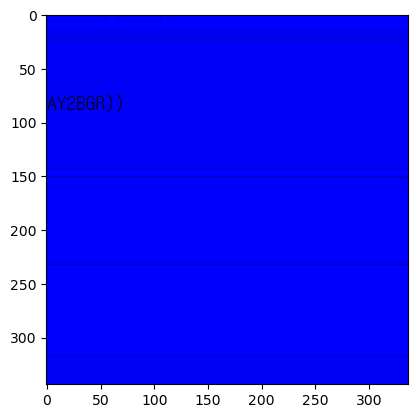

In [22]:
obs = env.get_observation()
done, done_cap = env.get_done()
plt.imshow(cv2.cvtColor(obs[0],cv2.COLOR_GRAY2BGR))
print(done)
plt.imshow(done_cap)

# 3. Train the Model

## 3.1 Create Callback

In [23]:
# Import os for file path management
import os
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment
from stable_baselines3.common import env_checker

In [24]:
env_checker.check_env(env)

TypeError: CookieRun.reset() missing 1 required positional argument: 'seed'

In [247]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [248]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [249]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

## 3.2 Build () and Train

In [250]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [251]:
env = CookieRun()

In [252]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=1200000, learning_starts=1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\1567w\anaconda3\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
C:\Users\1567w\anaconda3\lib\site-packages\stable_baselines3\common\buffers.py:231: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 19.94GB > 7.64GB
  warnings.warn(


In [253]:
model.learn(total_timesteps=100000, callback=callback)

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

# 4. Test out Model